In [1]:
# To Do:
# - av en Wind protons
# intercal factor ephin legend: remove if 1

In [ ]:
# from IPython.core.display import display, HTML
# display(HTML(data="""<style> div#notebook-container { width: 80%; } div#menubar-container { width: 85%; } div#maintoolbar-container { width: 90%; } </style>"""))
from matplotlib.ticker import AutoMinorLocator#, LogLocator, NullFormatter, LinearLocator, MultipleLocator, 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rcParams['agg.path.chunksize'] = 20000
import numpy as np
import os
import pandas as pd
import datetime as dt
from seppy.loader.wind import wind3dp_load
from seppy.loader.soho import soho_load
# from other_loaders_py3 import wind_3dp_av_en  #, wind_mfi_loader, ERNE_HED_loader
from sunpy.coordinates import get_horizons_coord
from sunpy.coordinates import frames
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm

from soler.tools.my_func_py3 import mag_angles, polarity_rtn, resample_df
from soler.tools.polarity_plotting import polarity_rtn, polarity_panel, polarity_colorwheel
from soler.radio_plots.Wind_merged import load_wind_waves
#from other_loaders_py3 import wind_3dp_omni_loader, ERNE_HED_loader, eph_rl2_loader
#intensity_label = 'Intensity\n/(s cm² sr MeV)'
intensity_label = 'Intensity\n'+r'[(s cm² sr MeV)$^{-1}$]'

outpath = os.getcwd()
data_path = None  # '/Users/dresing/data/projects/wind/'
wind_data_path = None  # '/Users/jagies/data/wind/'
erne_data_path = None  # '/Users/jagies/data/soho/'
ephin_data_path = None  # '/Users/jagies/data/soho/'


In [2]:
def wind_mfi_loader(startdate, enddate):
    from sunpy.net import Fido
    from sunpy.net import attrs as a
    from sunpy.timeseries import TimeSeries

    dataset = 'WI_H3-RTN_MFI'  # 'WI_H2_MFI'
    cda_dataset = a.cdaweb.Dataset(dataset)

    trange = a.Time(startdate, enddate)

    # path = path_loc+'wind/mfi/'  # you can define here where the original data files should be saved, see 2 lines below
    path = None
    result = Fido.search(trange, cda_dataset)
    downloaded_files = Fido.fetch(result, path=path)  # use Fido.fetch(result, path='/ThisIs/MyPath/to/Data/{file}') to use a specific local folder for saving data files
    downloaded_files.sort()

    # read in data files to Pandas Dataframe
    data = TimeSeries(downloaded_files, concatenate=True)
    df = data.to_dataframe()

    # wind_datetime = np.arange(concat_df.shape[0]) * datetime.timedelta(hours=1)
    # for i in range(concat_df.shape[0]):
    #     dt64=df.index[i]
    #     ts=(dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    #     wind_datetime[i]=datetime.datetime.utcfromtimestamp(ts)

    # df['BR'], df['BT'], df['BN'] = cs.cxform('GSE','RTN', wind_datetime, x=df['BGSE_0'], y=df['BGSE_1'], z=df['BGSE_2'])
    # df['B'] = np.sqrt(df['BGSE_0'].values**2+df['BGSE_1'].values**2 +df['BGSE_2'].values**2)
    df['B'] = np.sqrt(df['BRTN_0'].values**2+df['BRTN_1'].values**2 +df['BRTN_2'].values**2)
    # return concat_df
    return  df

In [3]:
#year = 2024
#startdate = dt.datetime(year, 5, 13,0)
#enddate = dt.datetime(year, 5, 14, 12)

year = 2024
startdate = X1 = dt.datetime(year, 1, 14,10)
enddate = X2 = dt.datetime(year, 1, 16, 8)

erne = True
plot_ephin = True
if plot_ephin:
    eph_e_ch = 'E150'
    intercal = 1  #14.
    eph_p_ch = 'P25'
wind = True
wind_ev2MeV_fac = 1e6
wind_flux_thres = None

plot_lines = False

# averaging intervals
av_sep = '20min'
av_mag =  '1min'
av_erne = '10min'

In [4]:
save_fig = False

plot_electrons = True
plot_protons = True
plot_pad = False
plot_mag_angles = True 
plot_mag = True
plot_Vsw = True
plot_N = True
plot_T = True
plot_polarity = True 


panels = 1*plot_electrons + 1*plot_protons + 1*plot_pad + 2*plot_mag_angles + 1*plot_mag + 1* plot_Vsw + 1* plot_N + 1* plot_T

panel_ratios = list(np.zeros(panels)+1)
if plot_electrons and plot_protons:
    panel_ratios[0] = 2
    panel_ratios[1] = 2
if plot_electrons or plot_protons:    
    panel_ratios[0] = 2

In [5]:
# LOAD DATA
####################################################################
if wind:
    edic_, meta_e = wind3dp_load(dataset="WI_SFSP_3DP",
                        startdate=startdate,
                        enddate=enddate,
                        resample=0,
                        multi_index=True,
                        path=wind_data_path,
                        threshold=wind_flux_thres)
    pdic_, meta_p = wind3dp_load(dataset="WI_SOSP_3DP",
                        startdate=startdate,
                        enddate=enddate,
                        resample=0,
                        multi_index=True,
                        path=wind_data_path,
                        threshold=wind_flux_thres)

if plot_ephin:
    dataset="SOHO_COSTEP-EPHIN_L2-1MIN"
    ephin_, meta_ephin = soho_load(dataset=dataset, startdate=startdate, enddate=enddate,
                     path=ephin_data_path, resample=None, pos_timestamp=None)

mag_data = wind_mfi_loader(startdate, enddate)
mag_data = resample_df(mag_data, '1min')  # resampling to 1min for polarity plot

100%|########################################| 491k/491k [00:00<00:00, 482MB/s]


100%|########################################| 496k/496k [00:00<00:00, 490MB/s]


100%|###############################################| 487k/487k [00:00<?, ?B/s]


100%|#############################################| 31.4k/31.4k [00:00<?, ?B/s]




Multi-index function only available (and necessary) for pitch-angle resolved fluxes. Skipping.


100%|########################################| 599k/599k [00:00<00:00, 392MB/s]


100%|#######################################| 606k/606k [00:00<00:00, 69.6MB/s]


100%|########################################| 596k/596k [00:00<00:00, 127MB/s]


100%|#############################################| 31.5k/31.5k [00:00<?, ?B/s]




Multi-index function only available (and necessary) for pitch-angle resolved fluxes. Skipping.
File epi24014.rl2 not found locally at C:/Users/osant/sunpy/data\.


100%|#######################################| 373k/373k [00:00<00:00, 47.3MB/s]



File epi24015.rl2 not found locally at C:/Users/osant/sunpy/data\.


100%|###############################################| 373k/373k [00:00<?, ?B/s]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

wi_h3-rtn_mfi_20240115_v04.cdf:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

wi_h3-rtn_mfi_20240116_v04.cdf:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

wi_h3-rtn_mfi_20240114_v04.cdf:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

In [6]:
if erne:
    dataset="SOHO_ERNE-HED_L2-1MIN"
    erne_p_, meta_erne = soho_load(dataset=dataset, startdate=startdate, enddate=enddate,
                        path=erne_data_path, resample=None, pos_timestamp=None)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

soho_erne-hed_l2-1min_20240114_v01.cdf:   0%|          | 0.00/278k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

soho_erne-hed_l2-1min_20240115_v01.cdf:   0%|          | 0.00/279k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

soho_erne-hed_l2-1min_20240116_v01.cdf:   0%|          | 0.00/278k [00:00<?, ?B/s]

In [7]:
#product = a.cdaweb.Dataset('AC_K0_SWE')
#product = a.cdaweb.Dataset('WI_PLSP_3DP')
#product = a.cdaweb.Dataset('WI_PM_3DP')  
if plot_Vsw or plot_N or plot_T:
    product = a.cdaweb.Dataset('WI_K0_3DP')

    time = a.Time(startdate, enddate)
    result = Fido.search(time & product)
    files = Fido.fetch(result, path=data_path)
    data = TimeSeries(files, concatenate=True)
    df_solwind = data.to_dataframe()
    df_solwind['vsw'] = np.sqrt(df_solwind['ion_vel_0']**2 + df_solwind['ion_vel_1']**2 + df_solwind['ion_vel_2']**2)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

wi_k0_3dp_20240116_v01.cdf:   0%|          | 0.00/190k [00:00<?, ?B/s]

wi_k0_3dp_20240115_v01.cdf:   0%|          | 0.00/190k [00:00<?, ?B/s]

wi_k0_3dp_20240114_v01.cdf:   0%|          | 0.00/190k [00:00<?, ?B/s]

2025-03-04 12:15:28 - sunpy - WARNING: SunpyUserWarning: No units provided for variable "Time_PB5". Assigning dimensionless units.
2025-03-04 12:15:28 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "pfu". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 12:15:28 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "eV/cm^2-s". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 12:15:28 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "pfu". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 12:15:28 - sunpy - WARNING: SunpyUserWarning: No units provided for variable "Time_PB5". Assigning dimensionless unit

In [8]:
# AVERAGING
if av_mag is not None:
    mag_df = resample_df(mag_data, av_mag)
    if plot_Vsw or plot_N or plot_T:
        vsw_df = resample_df(df_solwind, av_mag)
else:
    mag_df = mag_data
    if plot_Vsw or plot_T or plot_N:
        vsw_df = df_solwind
    
if av_sep is not None:
    edic = resample_df(edic_, av_sep)
    pdic = resample_df(pdic_, av_sep)
    if plot_ephin:
        ephin = resample_df(ephin_, av_sep)
    if erne:
        erne_p = resample_df(erne_p_, av_erne)
else:
    edic = edic_
    pdic = pdic_
    if plot_ephin:
        ephin = ephin_
    if erne:
        erne_p = erne_p_
    
# add particles, SWE    

<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:129: SyntaxWarning: invalid escape sequence '\m'
C:\Users\osant\AppData\Local\Temp\ipykernel_23388\352457155.py:129: SyntaxWarning: invalid escape sequence '\m'
  axs[i].set_ylabel("N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)
2025-03-04 12:15:37 - sunpy - INFO: Obtained JPL HORIZONS location for Wind (spacecraft) (-8)         


INFO: Obtained JPL HORIZONS location for Wind (spacecraft) (-8)          [sunpy.coordinates.ephemeris]


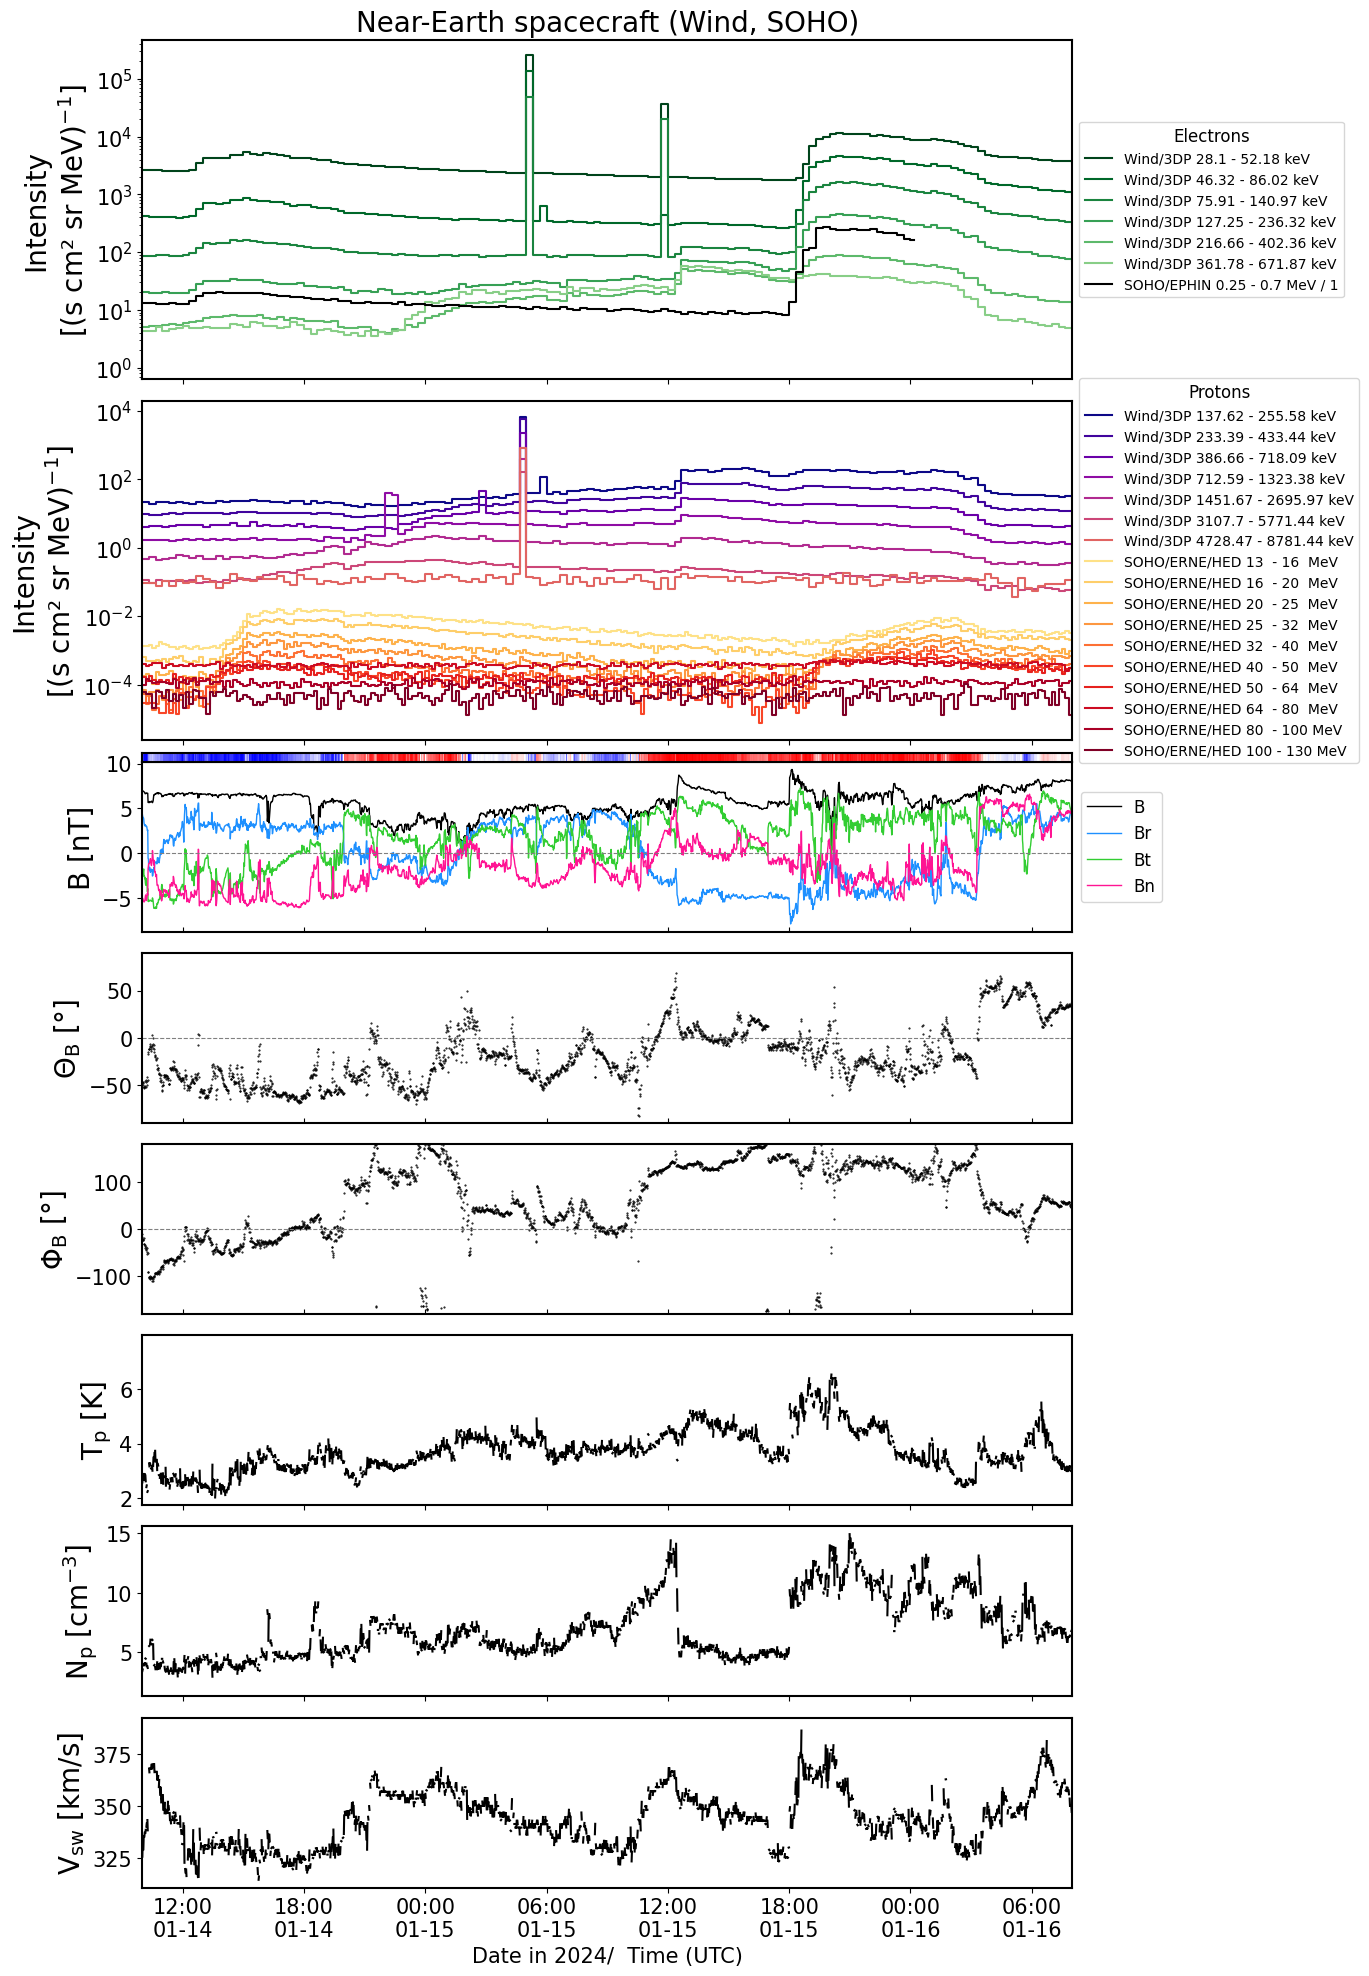

In [9]:
# 
#%matplotlib notebook
# PLOT
####################################################################
i=0
if panels == 3:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 4*panels])#, gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
else:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 3*panels], gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
    #fig, axs = plt.subplots(nrows=panels, sharex=True, dpi=100, figsize=[7, 1.5*panels], gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")

    
fig.subplots_adjust(hspace=0.1)

if panels == 1:
    axs = [axs, axs]

font_ylabel = 20
font_legend = 10
color_offset = 3


if plot_electrons:
    # electrons
    ax = axs[i]
    axs[i].set_prop_cycle('color', plt.cm.Greens_r(np.linspace(0,1, len(meta_e['channels_dict_df'])+color_offset)))
    if wind:
        for ch in np.arange(1, len(meta_e['channels_dict_df'])):
            ax.plot(edic.index, edic[f'FLUX_{ch}'] * wind_ev2MeV_fac, label='Wind/3DP '+meta_e['channels_dict_df']['Bins_Text'].values[ch], drawstyle='steps-mid')
    
    
    if plot_ephin:
        ax.plot(ephin.index, ephin[eph_e_ch]*intercal, '-k', label='SOHO/EPHIN '+meta_ephin[eph_e_ch]+f' / {intercal}', drawstyle='steps-mid')
    # ax.set_ylim(1e0, 1e4)
    ax.legend(title='Electrons', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_legend)
    ax.set_yscale('log')
    ax.set_ylabel(intensity_label, fontsize=font_ylabel)
    i += 1
    
color_offset = 2    
if plot_protons:    
    # protons low en:
    ax = axs[i]
    ax.set_prop_cycle('color', plt.cm.plasma(np.linspace(0,1, len(meta_p['channels_dict_df'])+color_offset)))
    if wind:
        for ch in np.arange(2, len(meta_p['channels_dict_df'])):
            ax.plot(pdic.index, pdic[f'FLUX_{ch}'] * wind_ev2MeV_fac, label='Wind/3DP '+meta_p['channels_dict_df']['Bins_Text'].values[ch],
                    drawstyle='steps-mid')
    ax.legend(title='Protons', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale('log')
    ax.set_ylabel(intensity_label, fontsize=font_ylabel)

    # protons high en:
    if erne:
        ax.set_prop_cycle('color', plt.cm.YlOrRd(np.linspace(0.2,1,10))) #cm.RdPu_r
        for ch in np.arange(0, 10):
            ax.plot(erne_p.index, erne_p[f'PH_{ch}'], label='SOHO/ERNE/HED '+meta_erne['channels_dict_df_p']['ch_strings'][ch], 
                        drawstyle='steps-mid')
    ax.legend(title='Protons', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_legend)
    ax.set_yscale('log')
    i += 1

    
    
if plot_mag:    
    ax = axs[i]
    ax.plot(mag_df.index, mag_df.B.values, label='B', color='k', linewidth=1)
    ax.plot(mag_df.index, mag_df.BRTN_0.values, label='Br', color='dodgerblue', linewidth=1)
    ax.plot(mag_df.index, mag_df.BRTN_1.values, label='Bt', color='limegreen', linewidth=1)
    ax.plot(mag_df.index, mag_df.BRTN_2.values, label='Bn', color='deeppink', linewidth=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, title='RTN')#, bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('B [nT]', fontsize=font_ylabel)
    ax.tick_params(axis="x",direction="in", which='both') #, pad=-15
    i += 1
    
if plot_polarity:
    pos = get_horizons_coord('Wind', time={'start':mag_data.index[0]-pd.Timedelta(minutes=15),
                                           'stop':mag_data.index[-1]+pd.Timedelta(minutes=15),'step':"1min"}) 
                                            # (lon, lat, radius) in (deg, deg, AU)
    pos = pos.transform_to(frames.HeliographicStonyhurst())
    #Interpolate position data to magnetic field data cadence
    r = np.interp([t.timestamp() for t in mag_data.index],[t.timestamp() for t in pd.to_datetime(pos.obstime.value)],pos.radius.value)
    lat = np.interp([t.timestamp() for t in mag_data.index],[t.timestamp() for t in pd.to_datetime(pos.obstime.value)],pos.lat.value)
    pol, phi_relative = polarity_rtn(mag_data.BRTN_0.values, mag_data.BRTN_1.values, mag_data.BRTN_2.values,r,lat,V=400)
# create an inset axe in the current axe:
    pol_ax = inset_axes(ax, height="5%", width="100%", loc=9, bbox_to_anchor=(0.,0,1,1.1), bbox_transform=ax.transAxes) # center, you can check the different codes in plt.legend?
    pol_ax.get_xaxis().set_visible(False)
    pol_ax.get_yaxis().set_visible(False)
    pol_ax.set_ylim(0,1)
    pol_ax.set_xlim([mag_data.index.values[0], mag_data.index.values[-1]])
    pol_arr = np.zeros(len(pol))+1
    timestamp = mag_data.index.values[2] - mag_data.index.values[1]
    norm = Normalize(vmin=0, vmax=180, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
    pol_ax.bar(mag_data.index.values[(phi_relative>=0) & (phi_relative<180)],pol_arr[(phi_relative>=0) & (phi_relative<180)],color=mapper.to_rgba(phi_relative[(phi_relative>=0) & (phi_relative<180)]),width=timestamp)
    pol_ax.bar(mag_data.index.values[(phi_relative>=180) & (phi_relative<360)],pol_arr[(phi_relative>=180) & (phi_relative<360)],color=mapper.to_rgba(np.abs(360-phi_relative[(phi_relative>=180) & (phi_relative<360)])),width=timestamp)
    pol_ax.set_xlim(startdate, enddate)
    
    
if plot_mag_angles:
    alpha, phi = mag_angles(mag_df.B.values, mag_df.BRTN_0.values, mag_df.BRTN_1.values, mag_df.BRTN_2.values)
    ax = axs[i]
    ax.plot(mag_df.index, alpha, '.k', label='alpha', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-90, 90)
    ax.set_ylabel(r"$\Theta_\mathrm{B}$ [°]", fontsize=font_ylabel)
    ax.tick_params(axis="x",direction="in")
    i += 1
    
    ax = axs[i]
    ax.plot(mag_df.index, phi, '.k', label='phi', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-180, 180)
    ax.set_ylabel(r"$\Phi_\mathrm{B}$ [°]", fontsize=font_ylabel)
    ax.tick_params(axis="x",direction="in", which='both')
    i += 1
    
### Temperature
if plot_T:
    axs[i].plot(vsw_df.index, vsw_df['ion_temp'], '-k', label="Temperature")
    axs[i].set_ylabel(r"T$_\mathrm{p}$ [K]", fontsize=font_ylabel)
    i += 1

### Density
if plot_N:
    axs[i].plot(vsw_df.index, vsw_df.ion_density,
                '-k', label="Ion density")
    axs[i].set_ylabel("N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)
    i += 1

### Sws
if plot_Vsw:
    axs[i].plot(vsw_df.index, vsw_df.vsw,
                '-k', label="Bulk speed")
    axs[i].set_ylabel(r"V$_\mathrm{sw}$ [km/s]", fontsize=font_ylabel)
    i += 1
        

axs[0].set_title('Near-Earth spacecraft (Wind, SOHO)', fontsize=font_ylabel)
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d'))
axs[-1].xaxis.set_tick_params(rotation=0)
axs[-1].set_xlabel(f"Date in {year}/  Time (UTC)", fontsize=15)
axs[-1].set_xlim(startdate, enddate)


plot_lines = True
for ax in axs:
    #ax.tick_params(axis='both', labelsize=12)
    if plot_lines:
        #line = dt.datetime(year, 3, 15, 4)
        line = dt.datetime(year, 3, 13, 3, 15)
        ax.axvline(x=line, color='k', linestyle='--')

plt.show()
if save_fig:
    plt.savefig(f'{outpath}L1_multiplot_{str(startdate.date())}--{str(enddate.date())}_{av_sep}.png')
    #plt.close()